This notebook evaluates speed on a multi-attribute search task. 

We'll compare list comprehension, Pandas, SQLite (via LiteBox), HashBox, and FrozenHashBox. 

The results are:
 - Pandas and list comprehension take about **100ms**
 - LiteBox takes about **10ms**
 - HashBox takes takes **2ms** 
 - FrozenHashBox takes **1ms**

HashBox and FrozenHashBox are the winners, by a long shot.

In [14]:
import random
import pandas as pd

from functools import partial
from hashbox import HashBox, FrozenHashBox
from litebox import LiteBox


#### Let's make 2 million fruits of different sizes, shapes, colors, and types.

In [47]:
types = ['apple', 'grape', 'mango', 'banana', 'watermelon']
colors = ['red', 'orange', 'yellow', 'green', 'blue']
shapes = ['cube', 'sphere', 'pyramid', 'dodecahedron']

random.seed(1)
fruits = [
    {
        'size': random.randint(1, 100),
        'type': random.choice(types),
        'color': random.choice(colors),
        'shape': random.choice(shapes)
    }
    for i in range(2_000_000)
]

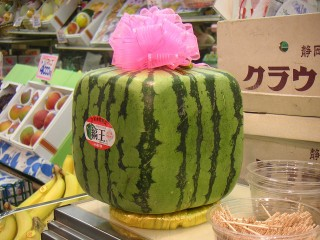

#### Goal: Find all the green cubic watermelons of size 50. 

In [48]:
# target properties
t_type='watermelon'
t_size=50
t_color='green'
t_shape='cube'

#### First, run each method and confirm it gives the correct number of results.

All methods should find the 196 fruits matching the criteria.

In [50]:
# List comprehension
def list_comprehension():
    return [f for f in fruits if f['type']==t_type and f['size']==t_size and f['color']==t_color and f['shape']==t_shape]

len(list_comprehension())

196

In [55]:
# Pandas
def pandas_query(df):
    return df.query(f'type == "{t_type}" and size == {t_size} and color == "{t_color}" and shape == "{t_shape}"')

df = pd.DataFrame.from_records(fruits)
len(pandas_query(df))

196

In [61]:
# LiteBox
def litebox_find(lb):
    return lb.find(f'type == "{t_type}" and size == {t_size} and color == "{t_color}" and shape == "{t_shape}"')

lb = LiteBox(fruits, {'type': str, 'size': int, 'color': str, 'shape': str})
len(litebox_find(lb))

196

In [66]:
# HashBox
def hashbox_find(hb):
    return hb.find({'type': t_type, 'size': t_size, 'color': t_color, 'shape': t_shape})

hb = HashBox(fruits, ['type', 'size', 'color', 'shape'])
len(hashbox_find(hb))

196

In [67]:
# FrozenHashBox
def frozen_hashbox_find(fhb):
    return fhb.find({'type': t_type, 'size': t_size, 'color': t_color, 'shape': t_shape})

fhb = FrozenHashBox(fruits, ['type', 'size', 'color', 'shape'])
len(frozen_hashbox_find(fhb))

196

#### OK, everything looks correct. Let's do timings!

In [68]:
%%timeit 
list_comprehension()

127 ms ± 4.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
%%timeit
pandas_query(df)

123 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
%%timeit
litebox_find(lb)

13.1 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
%%timeit
hashbox_find(hb)

2.24 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
%%timeit
frozen_hashbox_find(fhb)

1.11 ms ± 55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### HashBox and FrozenHashBox are pretty quick!